<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/MDF_Transporte_de_esp%C3%A9cies_com_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

Lx, Ly, Tmax = 10.0, 0.12, 20.0
Nx, Ny, Nt = 100, 20, 10000 #o motivo para ter um NT enorme é porque com valores menores, o codigo apresenta overflow
dx, dy, dt = Lx / (Nx - 1), Ly / (Ny - 1), Tmax / Nt
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

rho = 1000.0 #densidade da água
mu = 1e-3 #viscosidade dinâmica da água
alpha = mu / rho
D = 7.48e-3 #difusão

u = np.zeros((Ny, Nx)) #velocidade x
v = np.zeros((Ny, Nx)) #velocidade y
p = np.zeros((Ny, Nx)) #pressão
c = np.zeros((Ny, Nx)) #concentração MEG

iu, iv = 2.21, 0#velocidade inicial da água em x e em y
u[:, :] = iu
x_inj_index = int(2.0 / dx)#pontos de injeção de MEG
vel_inj_meg = 5e-3#velocidade da injeção de meg

def solve_navier_stokes(u, v, p, rho, mu, dt, dx, dy):
  un, vn, pn = u.copy(), v.copy(), p.copy()
  dpdx = (pn[:, 2:] - pn[:, :-2]) / (2 * dx)
  dpdy = (pn[2:, :] - pn[:-2, :]) / (2 * dy)

  lapu = (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) / dx ** 2 + \
       (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) / dy ** 2
  lapv = (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) / dx ** 2 + \
       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) / dy ** 2

  u[1:-1, 1:-1] = un[1:-1, 1:-1] - dt / rho * dpdx[1:-1, :] + alpha * dt * lapu
  v[1:-1, 1:-1] = vn[1:-1, 1:-1] - dt / rho * dpdy[:, 1:-1] + alpha * dt * lapv

  return u, v

results = []
save_steps = [0, int(0.25 * Nt), int(0.5 * Nt), int(0.75 * Nt), Nt - 1] #fazer uma plotagem em diferentes instantes de tempo

#Código MDF
for n in range(Nt):
  u, v = solve_navier_stokes(u, v, p, rho, mu, dt, dx, dy)
  c_new = c.copy()
  for j in range(1, Ny - 1):
    for i in range(1, Nx - 1):
      adv_x = -u[j, i] * (c[j, i] - c[j, i - 1]) / dx
      adv_y = -v[j, i] * (c[j, i] - c[j - 1, i]) / dy
      diff_x = D * (c[j, i + 1] - 2 * c[j, i] + c[j, i - 1]) / dx ** 2
      diff_y = D * (c[j + 1, i] - 2 * c[j, i] + c[j - 1, i]) / dy ** 2
      c_new[j, i] += dt * (adv_x + adv_y + diff_x + diff_y)

  c_new[:, 0] = 0.0
  c_new[:, -1] = c_new[:, -2]
  c_new[0, :] = c_new[1, :]
  c_new[-1, :] = c_new[-2, :]

  c_new[0, x_inj_index] = 1.0#O de cima é condição de contorno, aqui é a injeção de meg
  c_new[-1, x_inj_index] = 1.0

  c = c_new.copy()

  if n in save_steps:
    results.append(c.copy())

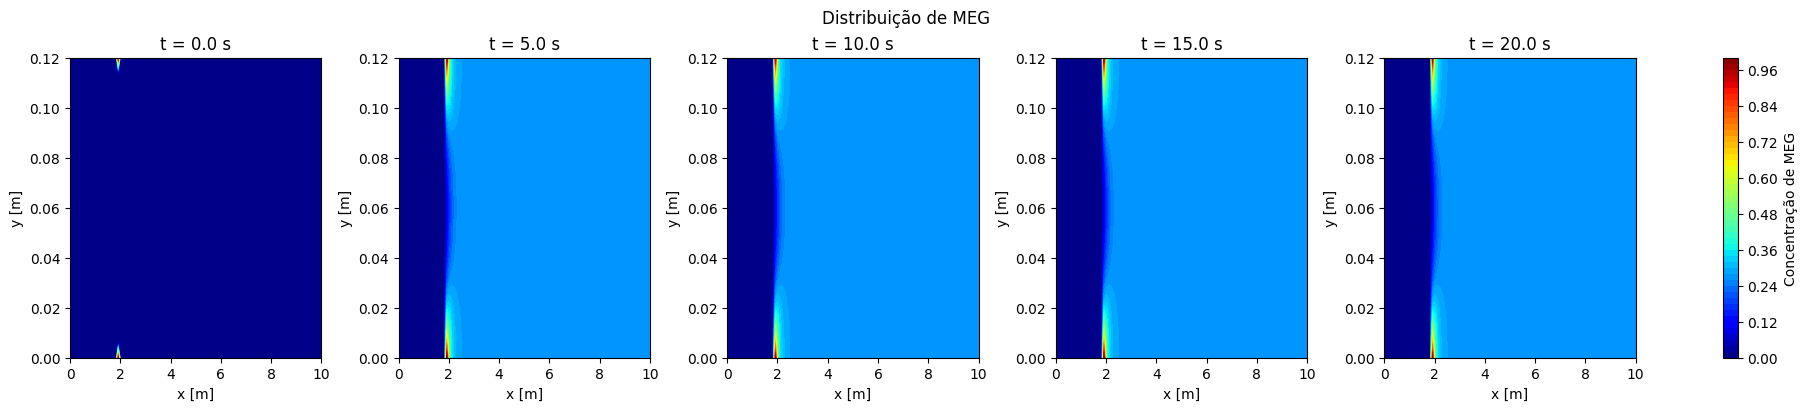

In [17]:
fig, axes = plt.subplots(1, len(results), figsize=(18, 4), constrained_layout=True)
for idx, ax in enumerate(axes):
  cf = ax.contourf(X, Y, results[idx], levels=50, cmap='jet')
  ax.set_title(f"t = {save_steps[idx]*dt:.1f} s")
  ax.set_xlabel("x [m]")
  ax.set_ylabel("y [m]")
fig.colorbar(cf, ax=axes.ravel().tolist(), label='Concentração de MEG')
plt.suptitle("Distribuição de MEG")
plt.show()